In [1]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!7z x /content/drive/MyDrive/CLAHE_new.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 319352072 bytes (305 MiB)

Extracting archive: /content/drive/MyDrive/CLAHE_new.zip
 27% 4096 Open              --
Path = /content/drive/MyDrive/CLAHE_new.zip
Type = zip
Physical Size = 319352072

  0%      3% 532 - CLAHE_new/1/14898_right.jpeg                                         6% 919 - CLAHE_new/1/28174_left.jpeg                                        8% 1238 - CLAHE_new/1/38188_right.jpeg

In [4]:
import pathlib
data_dir = '/content/CLAHE_new'
data_dir = pathlib.Path(data_dir)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 22 23:39:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import pathlib
data_dir = '/content/Classes'
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

15152


In [7]:
batch_size = 16
img_height = 299
img_width = 299

In [8]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 15152 files belonging to 2 classes.


In [9]:
class_names = dataset.class_names
print(class_names)

['0', '1']


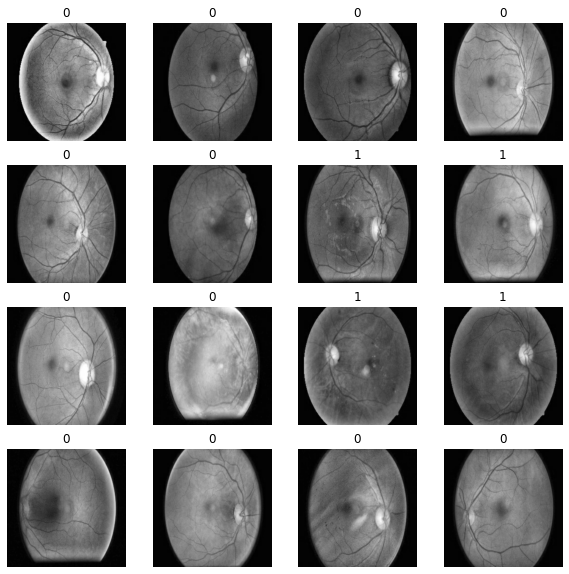

In [10]:
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15152 files belonging to 2 classes.
Using 10607 files for training.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15152 files belonging to 2 classes.
Using 4545 files for validation.


In [13]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [14]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.5, seed=None),
    layers.RandomCrop(150, 150, seed=None)
  ]
)

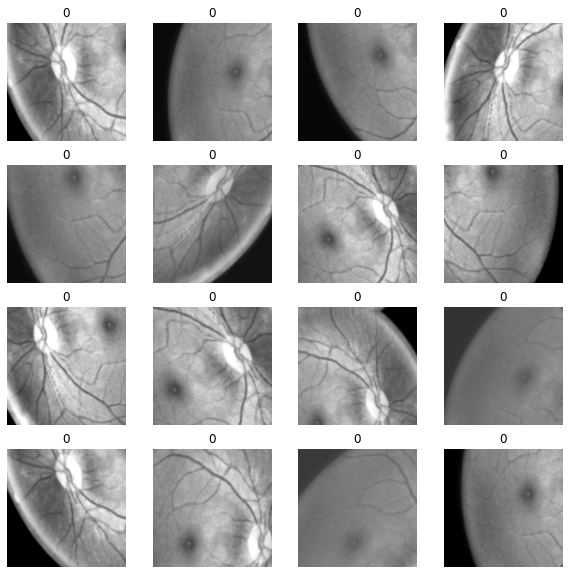

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(16):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

In [16]:
num_classes = len(class_names)

# Transfer Learning

In [17]:
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.models import Model

In [18]:
base_den = model = DenseNet201(weights='imagenet', include_top=False)
base_den.summary()

74836368/74836368 [==============================] - 3s 0us/step
Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                       

In [19]:
base_den.trainable = False

In [20]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_den(image_batch)
print(feature_batch.shape)

(16, 9, 9, 1920)


In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1920)


In [22]:
prediction_layer = tf.keras.layers.Dense(8, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 8)


In [23]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_den(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.05)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
import time
start_cnn = time.time()

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model_den.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=5)

callback_list = [checkpoint,es]

In [27]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callback_list  
)

Epoch 1/100
663/663 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.6316
Epoch 1: val_accuracy improved from -inf to 0.66271, saving model to best_model_den.hdf5
663/663 [==============================] - 151s 207ms/step - loss: 0.6897 - accuracy: 0.6316 - val_loss: 0.7571 - val_accuracy: 0.6627
Epoch 2/100
663/663 [==============================] - ETA: 0s - loss: 0.6479 - accuracy: 0.6535
Epoch 2: val_accuracy improved from 0.66271 to 0.66469, saving model to best_model_den.hdf5
663/663 [==============================] - 126s 190ms/step - loss: 0.6479 - accuracy: 0.6535 - val_loss: 0.6872 - val_accuracy: 0.6647
Epoch 3/100
663/663 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.6570
Epoch 3: val_accuracy improved from 0.66469 to 0.67789, saving model to best_model_den.hdf5
663/663 [==============================] - 125s 189ms/step - loss: 0.6452 - accuracy: 0.6570 - val_loss: 0.6242 - val_accuracy: 0.6779
Epoch 4/100
663/663 [==========

In [ ]:
print("Total time: ", time.time() - start_cnn, "seconds")

In [28]:
scores = model.evaluate(train_ds)

663/663 [==============================] - 88s 133ms/step - loss: 0.6112 - accuracy: 0.6808


In [29]:
scores = model.evaluate(val_ds)

285/285 [==============================] - 38s 132ms/step - loss: 0.6441 - accuracy: 0.6766


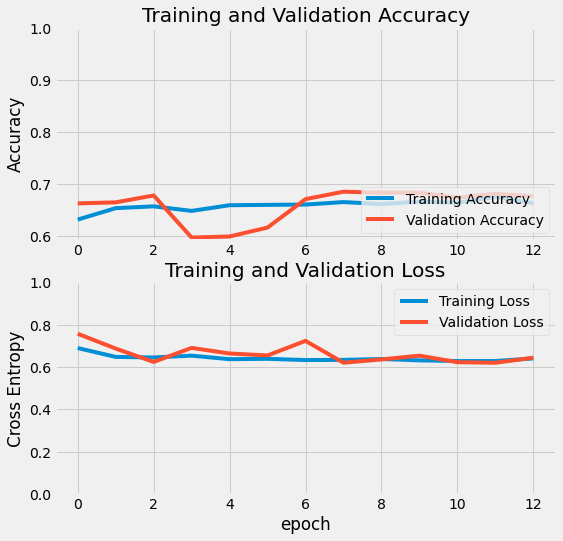

In [30]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Actual label: 0
1/1 [==============================] - 3s 3s/step
[8.2287997e-01 1.7711997e-01 1.8915588e-11 5.1487009e-10 9.6134774e-11
 6.5219732e-11 3.9265053e-11 4.1481866e-12]
predicted label: 0


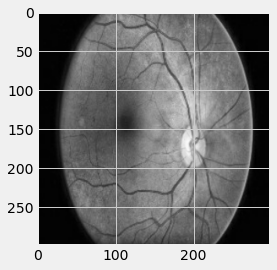

In [31]:
import numpy as np
for images_batch, labels_batch in val_ds.take(1):
    
    first_image = images_batch[5].numpy().astype('uint8')
    first_label = labels_batch[5].numpy()

    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[5])
    print("predicted label:",class_names[np.argmax(batch_prediction[5])])

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


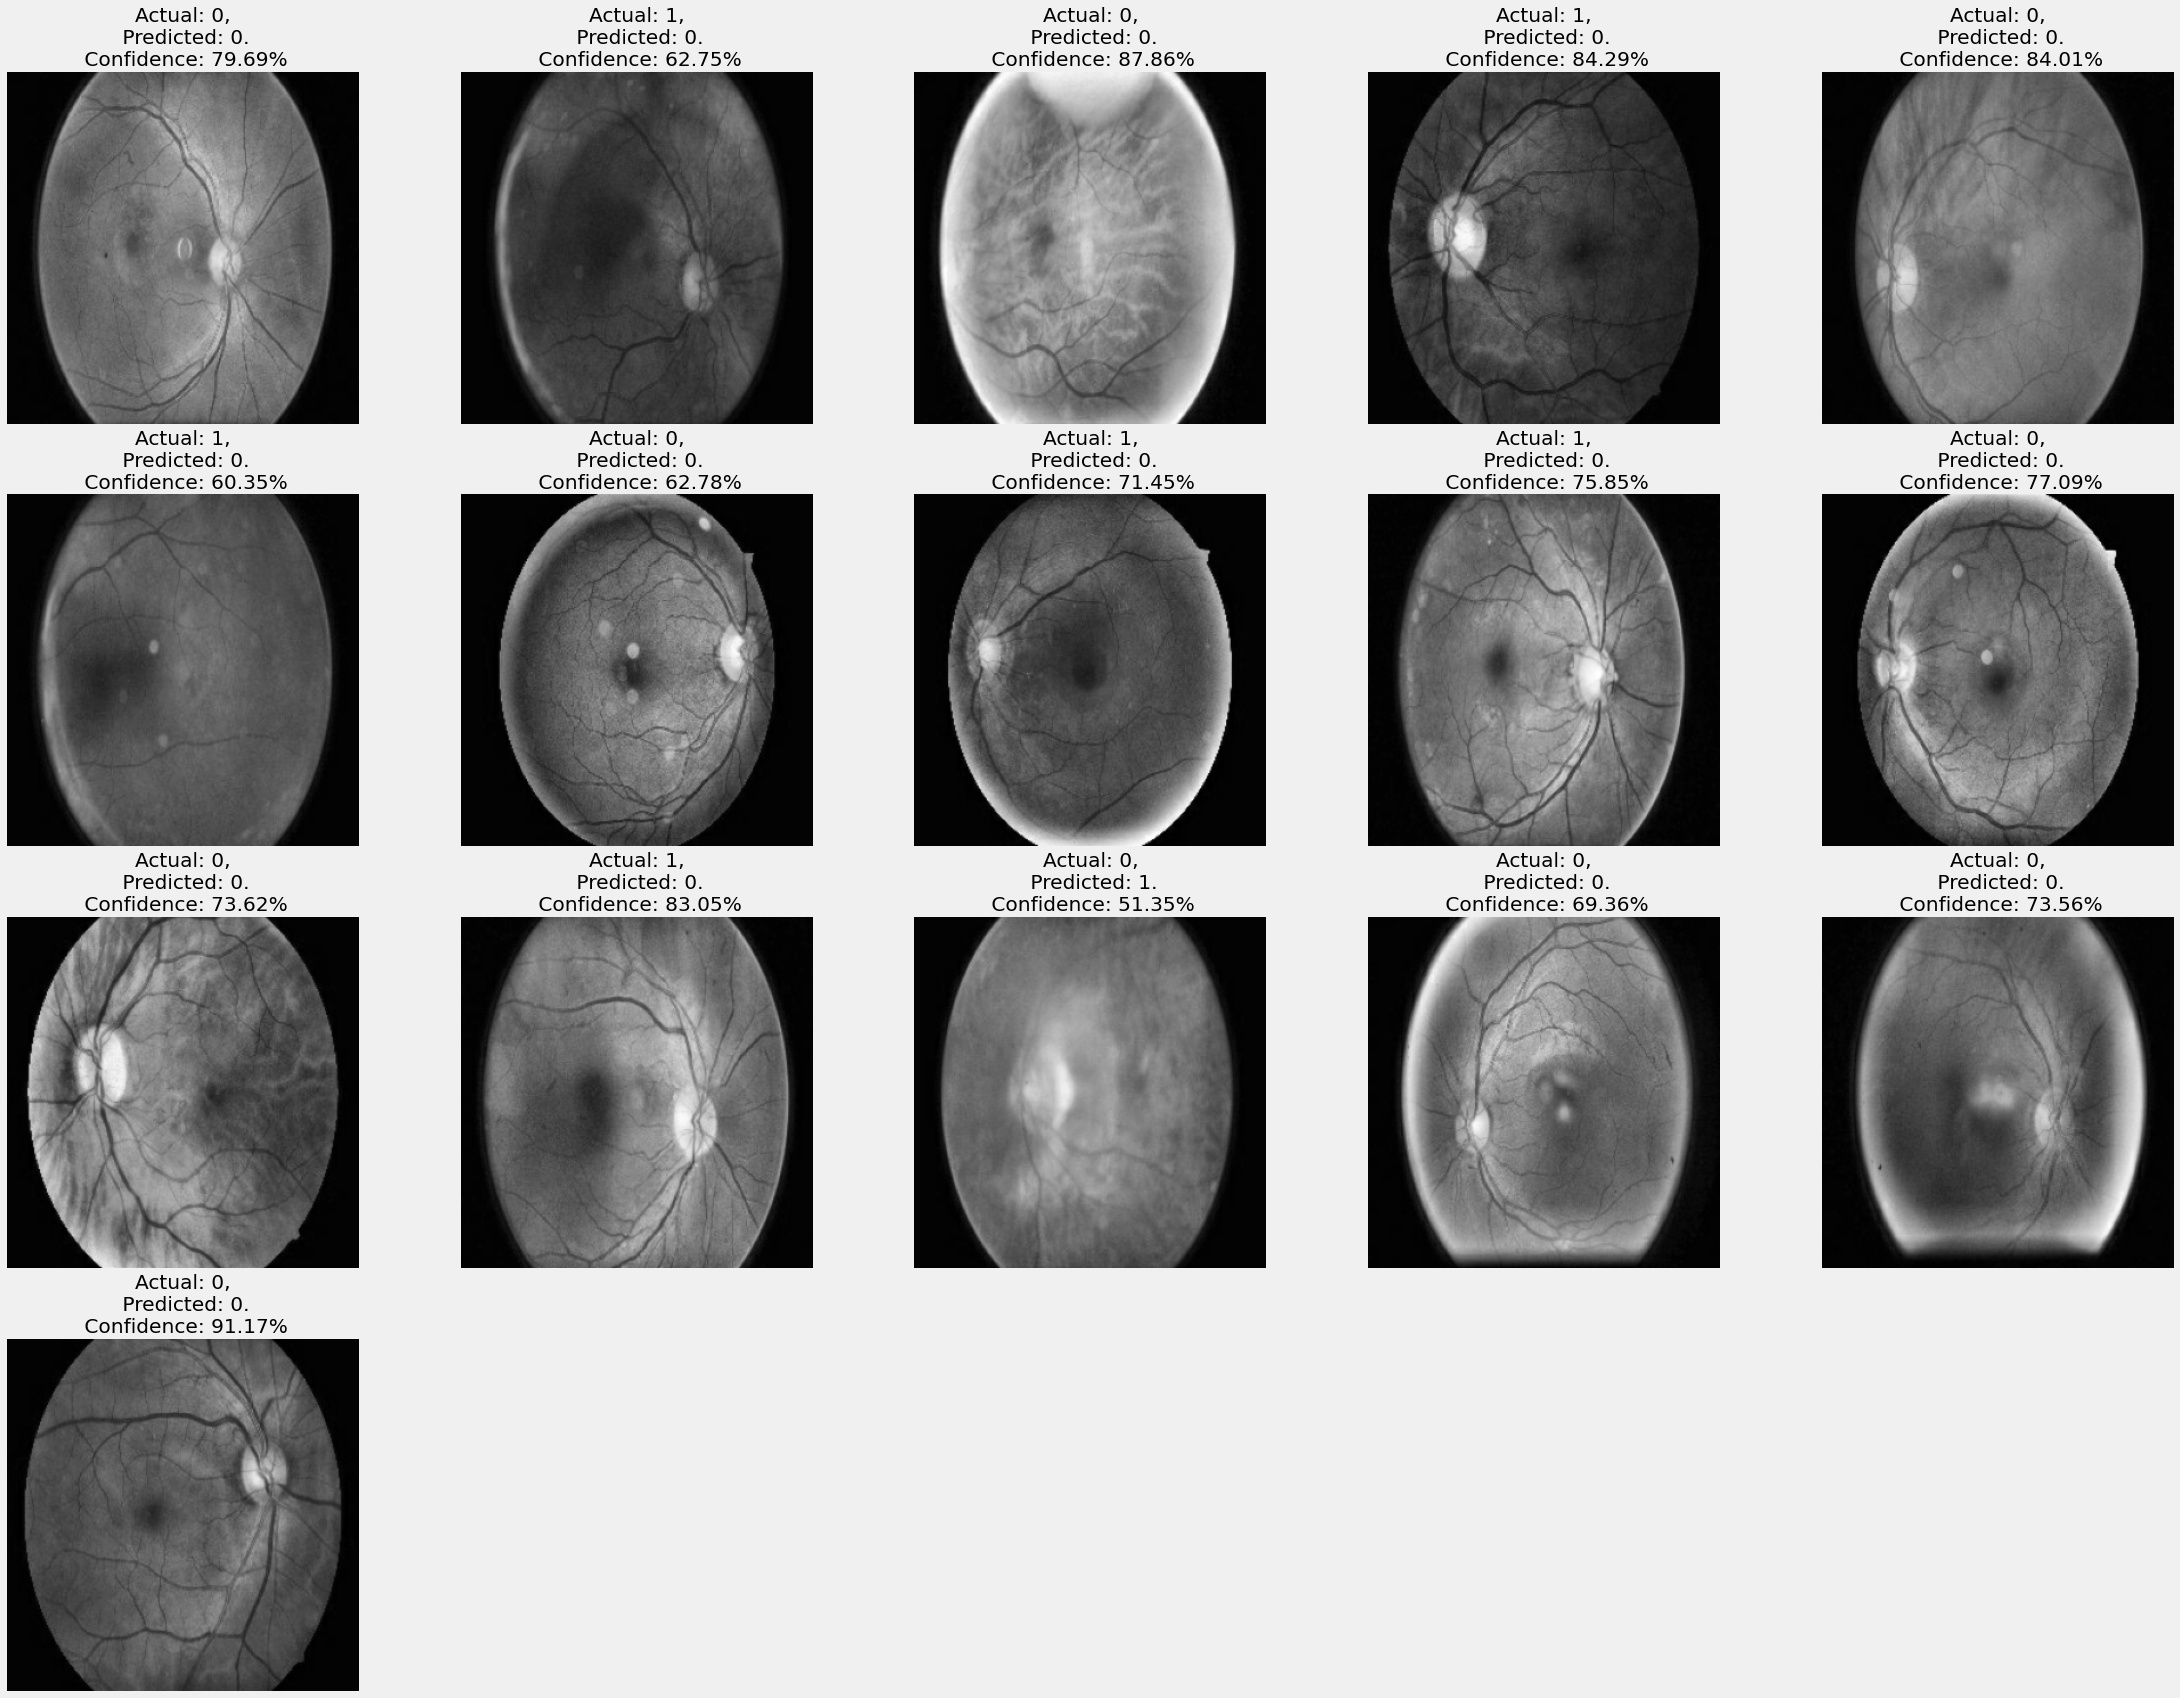

In [33]:
plt.figure(figsize=(35, 35))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [34]:
X = []
y = []
for image,labels in val_ds.take(96):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list)   

In [35]:
x = np.array(X)

In [36]:
y = np.array(y)

In [37]:
x.shape, y.shape

((1521, 299, 299, 3), (1521,))

In [38]:
model.evaluate(x[:1521],y[:1521])

48/48 [==============================] - 21s 328ms/step - loss: 0.6549 - accuracy: 0.6706


[0.6549454927444458, 0.6706114411354065]

In [39]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:1521])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:1521], y_pred_classes))

48/48 [==============================] - 12s 247ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.97      0.80      1003
           1       0.61      0.09      0.16       518

    accuracy                           0.67      1521
   macro avg       0.64      0.53      0.48      1521
weighted avg       0.65      0.67      0.58      1521

